# **Resume Prediction**
    Predicting Resume using LSTM 
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Dropout,LSTM,GRU,Embedding
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

2025-06-07 18:28:49.344302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749320929.512982      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749320929.559603      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
plt.style.use('ggplot')
%matplotlib inline

In [4]:
df = pd.read_csv('/kaggle/input/resume-datset/data.csv')
df.head(3)

,Unnamed: 0,Job Title,Job Description
0,0,Flutter Developer,We are looking for hire experts flutter develo...
1,1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."


In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Job Title,Job Description
0,Flutter Developer,We are looking for hire experts flutter develo...
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,Full Stack Developer,job responsibility full stack engineer – react...


In [6]:
df.columns

Index(['Job Title', 'Job Description'], dtype='object')

In [7]:
import re
stopwords_set = set(stopwords.words('english'))
emoji = re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')

def Clean_text(text):
    cleanText = re.sub('http\S+\s', ' ', text)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)  
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText) 
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText

In [8]:
X = df['Job Description'].apply(lambda x:Clean_text(x))
y = df['Job Title']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len = max(len(x) for x in sequences)
print(max_len)

1634


In [10]:
vocab_size = len(tokenizer.word_index) +1

In [11]:
sequences_data = pad_sequences(sequences,maxlen=max_len,padding='pre')
sequences_data

array([[    0,     0,     0, ...,     2,   392,   386],
       [    0,     0,     0, ...,   111,    65, 10226],
       [    0,     0,     0, ...,  2499,  3194,   507],
       ...,
       [    0,     0,     0, ...,  1643,  1447,    29],
       [    0,     0,     0, ...,    12,  1574,  2898],
       [    0,     0,     0, ...,  1464,    34,   183]], dtype=int32)

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [13]:
y = encoder.fit_transform(y)

In [14]:
len(encoder.classes_)

15

In [15]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    sequences_data, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # optional, use if classification labels are imbalanced
)


In [16]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1821, 1634), (456, 1634), (1821,), (456,))

In [17]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(15,activation='softmax')) 
model.build((None, max_len))

I0000 00:00:1749320942.966539      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749320942.967336      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1634, 128)           │       2,086,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1634, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1634, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,268,367 (8.65 MB)

 Trainable params: 2,268,367 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     # you can also use 'val_accuracy'
    patience=2,             # stop if no improvement for 2 epochs
    restore_best_weights=True
)

In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
    callbacks=[early_stop])

Epoch 1/100


I0000 00:00:1749320948.285430      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.1037 - loss: 2.6499
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2045 - loss: 2.2249
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3401 - loss: 1.8468
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.4033 - loss: 1.5671
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5502 - loss: 1.3243
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.6543 - loss: 1.0724
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.7300 - loss: 0.8722
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7448 - loss: 0.7923
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8052 - loss: 0.6445
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8538 - loss: 0.4920
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8775 - loss: 0.4398
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy

In [21]:
model.save('model.h5')

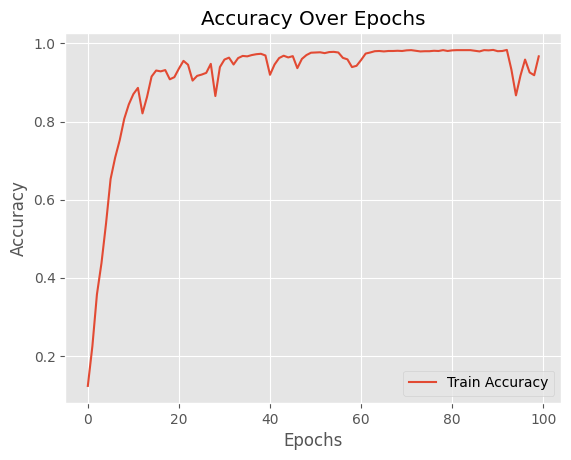

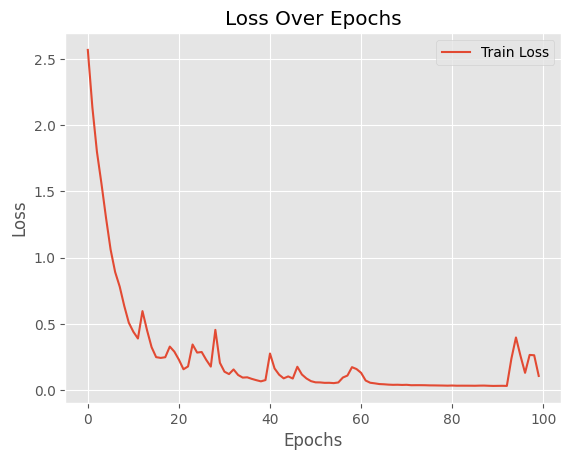

In [22]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Get predicted class indexes
y_pred = np.argmax(y_pred_prob, axis=1)

# y_test is already label-encoded
y_true = y_test


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


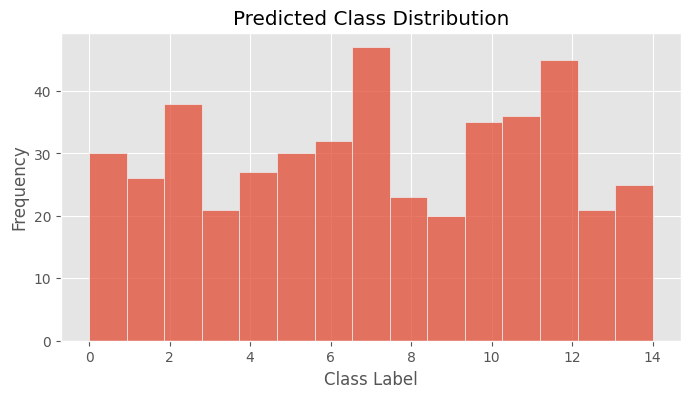

In [24]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(y_pred, bins=len(np.unique(y_pred)), kde=False)
plt.title('Predicted Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()


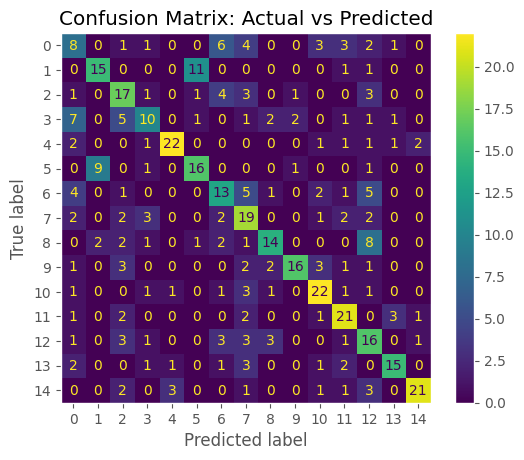

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix: Actual vs Predicted")
plt.grid(False)
plt.show()
